In [1]:
import polaris as po
import os
os.environ["AWS_DEFAULT_REGION"] = "auto"
           
competition = po.load_competition("asap-discovery/antiviral-ligand-poses-2025")

[2025-02-06 08:03:26] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=185693;file:///Users/jenkescheen/projects/polaris/polaris/polaris/_artifact.py\_artifact.py]8;;\:]8;id=345328;file:///Users/jenkescheen/projects/polaris/polaris/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.7).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=832127;file:///Users/jenkescheen/projects/polaris/polaris/polaris/dataset/_base.py\_base.py]8;;\:]8;id=328606;file:///Users/jenkescheen/projects/polaris/polaris/polaris/dataset/_base.py#182\182]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

In [2]:
competition.cache()


Output()

[08:03:29] Copying to destination                                                                      ]8;id=691210;file:///Users/jenkescheen/projects/polaris/polaris/polaris/dataset/_base.py\_base.py]8;;\:]8;id=517018;file:///Users/jenkescheen/projects/polaris/polaris/polaris/dataset/_base.py#381\381]8;;\
           /Users/jenkescheen/Library/Caches/polaris/datasets/d4b59585-d315-42fa-ae84-9e05e424681b/dat             
           a.zarr                                                                                                  

           For large Zarr archives, this may take a while.                                             ]8;id=473532;file:///Users/jenkescheen/projects/polaris/polaris/polaris/dataset/_base.py\_base.py]8;;\:]8;id=214179;file:///Users/jenkescheen/projects/polaris/polaris/polaris/dataset/_base.py#382\382]8;;\

[08:03:43]  Success: Copying Zarr keys                                                                ]8;id=456559;file:///Users/jenkescheen/projects/polaris/polaris/polaris/utils/context.py\context.py]8;;\:]8;id=728050;file:///Users/jenkescheen/projects/polaris/polaris/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=617999;file:///Users/jenkescheen/projects/polaris/polaris/polaris/utils/context.py\context.py]8;;\:]8;id=546429;file:///Users/jenkescheen/projects/polaris/polaris/polaris/utils/context.py#53\53]8;;\

'/Users/jenkescheen/Library/Caches/polaris/datasets/d4b59585-d315-42fa-ae84-9e05e424681b'

In [3]:
train, test = competition.get_train_test_split()


In [4]:
test[0]

{'Chain B Sequence': 'SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIMGV',
 'CXSMILES': 'O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cncc3ccccc13)C[C@@H]2CNc1ncncn1',
 'Chain A Sequence': 'SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIMGV',
 'Protein Label': 'MERS-CoV Mpro'}

In [5]:
prot_labels = [t["Protein Label"] for t in test]

In [6]:
test_smiles = [t["CXSMILES"] for t in test]

In [17]:
writer = Chem.SDWriter("ligand_194.sdf")

writer.write(Chem.MolFromSmiles(test_smiles[-1]))

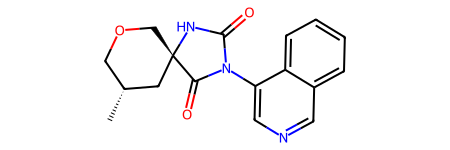

In [16]:
Chem.MolFromSmiles(test_smiles[-1])

## Load GNINA outputs

In [28]:
from rdkit import DataStructs, Chem
from rdkit.Chem import AllChem
import base64

def serialize_rdkit_mol(mol: Chem.Mol): 
    props = Chem.PropertyPickleOptions.AllProps
    mol_bytes = mol.ToBinary(props)
    return base64.b64encode(mol_bytes).decode('ascii')  

In [30]:
fpgen = AllChem.GetRDKitFPGenerator()

submissions_sars_cov_2 = []
submissions_mers_cov = []
for i, test_smi in enumerate(test_smiles) :
    # these were docked directly into the reference structures, so no need to align.
    sars_cov_2_pred_pose = Chem.SDMolSupplier(f"input_folders/ligand_{i}/docked_SARS-CoV-2.sdf")[0]
    mers_cov_pred_pose = Chem.SDMolSupplier(f"input_folders/ligand_{i}/docked_MERS-CoV.sdf")[0]

    # looks like stereo isn't abstracted from the predicted poses (in our case) so can't compare SMILES directly.
    # we'll use fingerprint similarity instead.
    test_fp = fpgen.GetFingerprint(Chem.MolFromSmiles(test_smi))

    # check that the predicted and test ligand are the same, just to make sure that we're predicting on the correct ligand
    assert DataStructs.TanimotoSimilarity(fpgen.GetFingerprint(sars_cov_2_pred_pose), test_fp) == 1
    assert DataStructs.TanimotoSimilarity(fpgen.GetFingerprint(mers_cov_pred_pose), test_fp) == 1

    # add to the submissions lists
    submissions_sars_cov_2.append(serialize_rdkit_mol(sars_cov_2_pred_pose))
    submissions_mers_cov.append(serialize_rdkit_mol(mers_cov_pred_pose))

[07:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[07:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[07:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[07:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[07:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[07:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[07:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[07:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[07:37:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

## Submission to Polaris

In [32]:
competition.submit_predictions(
    predictions=submissions_sars_cov_2,
    prediction_name="asap-gnina-docking-baseline",
    prediction_owner="jscheen",
    report_url="https://www.example.com", 
    # The below metadata is optional, but recommended.
    github_url="https://github.com/polaris-hub/polaris",
    description="Baseline docking for model comparison (SARS-CoV-2 Mpro)",
    tags=["baseline"],
    user_attributes={"Framework": "GNINA", "Method": "GNINA"}
)

[07:39:29]  Success: Submitting competition predictions                                               ]8;id=409543;file:///Users/jenkescheen/projects/polaris/polaris/polaris/utils/context.py\context.py]8;;\:]8;id=195597;file:///Users/jenkescheen/projects/polaris/polaris/polaris/utils/context.py#53\53]8;;\

In [33]:
competition.submit_predictions(
    predictions=submissions_mers_cov,
    prediction_name="asap-gnina-docking-baseline",
    prediction_owner="jscheen",
    report_url="https://www.example.com", 
    # The below metadata is optional, but recommended.
    github_url="https://github.com/polaris-hub/polaris",
    description="Baseline docking for model comparison (MERS-CoV Mpro)",
    tags=["baseline"],
    user_attributes={"Framework": "GNINA", "Method": "GNINA"}
)

[07:40:35]  Success: Submitting competition predictions                                               ]8;id=857439;file:///Users/jenkescheen/projects/polaris/polaris/polaris/utils/context.py\context.py]8;;\:]8;id=146022;file:///Users/jenkescheen/projects/polaris/polaris/polaris/utils/context.py#53\53]8;;\